# Causal Masking – Rechenbeispiel (Decoder darf nicht in die Zukunft schauen)

Dieses Notebook zeigt an einem kleinen Beispiel, wie eine **kausale Maske** Attention auf vergangene Tokens begrenzt.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=3)


## 1) Mini-Sequenz und vereinfachte Q/K/V-Vektoren

In [2]:
tokens = ["Paris", "ist", "sehr", "alt"]

Q = np.array([[1.0, 0.5], [0.8, 1.0], [0.2, 1.2], [0.6, 0.9]])
K = np.array([[1.0, 0.2], [0.7, 1.0], [0.1, 1.1], [0.5, 0.8]])
V = np.array([[1.0, 0.0], [0.0, 1.0], [0.5, 0.7], [0.3, 0.9]])

pd.DataFrame(np.hstack([Q, K, V]), index=tokens, columns=["Q1","Q2","K1","K2","V1","V2"])


,Q1,Q2,K1,K2,V1,V2
Paris,1.0,0.5,1.0,0.2,1.0,0.0
ist,0.8,1.0,0.7,1.0,0.0,1.0
sehr,0.2,1.2,0.1,1.1,0.5,0.7
alt,0.6,0.9,0.5,0.8,0.3,0.9


## 2) Score-Matrix berechnen

Scaled Dot-Product: $S = QK^T / \sqrt{d_k}$

In [3]:
d_k = Q.shape[1]
S = (Q @ K.T) / np.sqrt(d_k)
pd.DataFrame(S, index=[f"q:{t}" for t in tokens], columns=[f"k:{t}" for t in tokens]).round(3)


,k:Paris,k:ist,k:sehr,k:alt
q:Paris,0.778,0.849,0.460,0.636
q:ist,0.707,1.103,0.834,0.849
q:sehr,0.311,0.948,0.948,0.750
q:alt,0.552,0.933,0.742,0.721


## 3) Kausale Maske erzeugen

In [4]:
n = len(tokens)
causal_mask = np.tril(np.ones((n, n), dtype=bool))
pd.DataFrame(causal_mask.astype(int), index=tokens, columns=tokens)


,Paris,ist,sehr,alt
Paris,1,0,0,0
ist,1,1,0,0
sehr,1,1,1,0
alt,1,1,1,1


## 4) Softmax ohne Maske vs. mit kausaler Maske

In [5]:
def softmax(x, axis=-1):
    x = np.asarray(x, dtype=float)
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=axis, keepdims=True)

A_no_mask = softmax(S, axis=1)
S_masked = np.where(causal_mask, S, -1e9)
A_causal = softmax(S_masked, axis=1)

print("Zeilensummen ohne Maske:", A_no_mask.sum(axis=1).round(3))
print("Zeilensummen mit Maske:", A_causal.sum(axis=1).round(3))
pd.DataFrame(A_causal, index=[f"q:{t}" for t in tokens], columns=[f"v:{t}" for t in tokens]).round(3)


Zeilensummen ohne Maske: [1. 1. 1. 1.]
Zeilensummen mit Maske: [1. 1. 1. 1.]


,v:Paris,v:ist,v:sehr,v:alt
q:Paris,1.000,0.000,0.000,0.000
q:ist,0.402,0.598,0.000,0.000
q:sehr,0.209,0.395,0.395,0.000
q:alt,0.206,0.301,0.249,0.244


## 5) Kontextvektoren vergleichen

In [6]:
C_no_mask = A_no_mask @ V
C_causal = A_causal @ V

pd.DataFrame(
    np.hstack([C_no_mask, C_causal]),
    index=tokens,
    columns=["ohne_c1","ohne_c2","causal_c1","causal_c2"]
).round(3)


,ohne_c1,ohne_c2,causal_c1,causal_c2
Paris,0.443,0.644,1.000,0.000
ist,0.401,0.695,0.402,0.598
sehr,0.381,0.728,0.407,0.672
alt,0.403,0.695,0.403,0.695


## 6) Fokus auf erstes und letztes Token

In [7]:
for i in [0, len(tokens)-1]:
    print(f"\nToken: {tokens[i]}")
    print("Attention ohne Maske:", np.round(A_no_mask[i], 3))
    print("Attention causal   :", np.round(A_causal[i], 3))



Token: Paris
Attention ohne Maske: [0.273 0.293 0.198 0.237]
Attention causal   : [1. 0. 0. 0.]

Token: alt
Attention ohne Maske: [0.206 0.301 0.249 0.244]
Attention causal   : [0.206 0.301 0.249 0.244]


## 7) Visualisierung

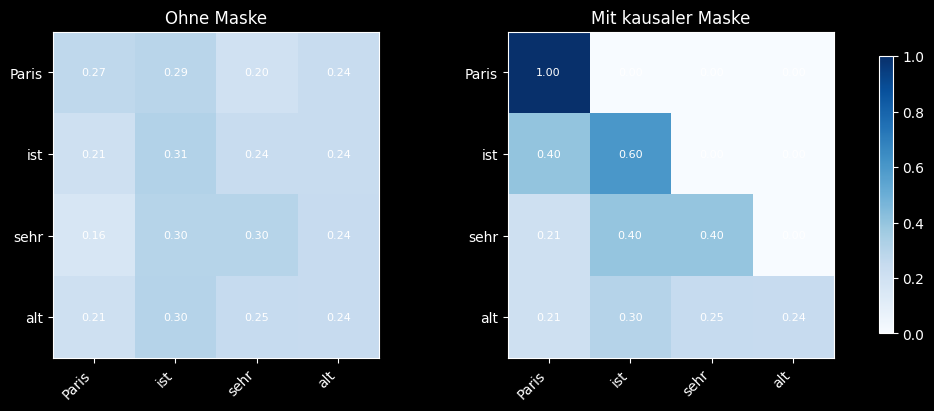

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for ax, mat, title in [(axes[0], A_no_mask, "Ohne Maske"), (axes[1], A_causal, "Mit kausaler Maske")]:
    im = ax.imshow(mat, cmap="Blues", vmin=0, vmax=1)
    ax.set_xticks(range(n), tokens, rotation=45, ha="right")
    ax.set_yticks(range(n), tokens)
    ax.set_title(title)
    for r in range(n):
        for col in range(n):
            ax.text(col, r, f"{mat[r,col]:.2f}", ha="center", va="center", fontsize=8)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.85)
plt.show()


## 8) Einordnung

- Decoder-Self-Attention nutzt kausale Maskierung gegen Zukunfts-Leakage.
- Das erste Token darf nur sich selbst sehen; spätere Tokens sehen mehr Kontext.